# Experimenting with pixel level classification of snow
Here we are using the Copernicus Scene Classification Label (SCL) as ground truth (GT).  To what extent can we reverse engineer the algoritmically defined SCL with simple machine learning?

In [1]:
import numpy as np
import pathlib
import glob
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import roc_auc_score, confusion_matrix


In [2]:
# Band meanings
bandMeanings = {
    0: "Coastal Aerosol",
    1: "Blue",
    2: "Green",
    3: "Red",
    4: "Vegetation Red Edge 1",
    5: "Vegetation Red Edge 2",
    6: "Vegetation Red Edge 3",
    7: "Near-Infrared",
    8: "Narrow Near-Infrared",
    9: "Water Vapor",
    10: "Cirrus",
    11: "Shortwave Infrared 1",
    12: "Shortwave Infrared 2"
}
bandMeanings

{0: 'Coastal Aerosol',
 1: 'Blue',
 2: 'Green',
 3: 'Red',
 4: 'Vegetation Red Edge 1',
 5: 'Vegetation Red Edge 2',
 6: 'Vegetation Red Edge 3',
 7: 'Near-Infrared',
 8: 'Narrow Near-Infrared',
 9: 'Water Vapor',
 10: 'Cirrus',
 11: 'Shortwave Infrared 1',
 12: 'Shortwave Infrared 2'}

In [3]:
# Lets build a pattern vector , n by m, where n=total number of pixels and m=13, form the L1C data
# Simultaneously read the snow GT from the L2A data

base_path = '../data_murray/'
l1c_glob_string = base_path + r'**/l1c/**/*.npy'
l2a_glob_string = base_path + r'**/l2a/**/*.npy'
print(l1c_glob_string)

l1c_list = sorted(list(glob.glob(l1c_glob_string, recursive=True)))
l2a_list = sorted(list(glob.glob(l2a_glob_string, recursive=True)))
print(len(l1c_list), len(l2a_list))
# assert len(l1c_list) == len(l2a_list)

../data_murray/**/l1c/**/*.npy
2230 2128


In [4]:
def find_corresponding_gt(p1, p2_list):
# Find the file l2a (ie GT) in flist which corresponds to the filename f which is a l1c file
    assert p1.find('/l1c/') > 0
    af = p1.replace('/l1c/', '/l2a/').replace('_MSIL1C_', '_MSIL2A_' )
    keystr = af[15:81]
    
    matches = [p for p in p2_list if p.find(keystr) > 0]
    assert len(matches) <= 1   # Problem if multiple matches
    if matches == []:
        return None
    else:
        return matches[0]
    
def test_find_corresponding_gt():
    p1 = "../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_20180913T114351_N0206_R123_T30VUJ_20180913T135232.SAFE.npy"
    p2 = find_corresponding_gt(p1, l2a_list)
    assert len(p1) == len(p2)
    print(p1)
    print(p2)
    diff = ''.join([c2 if c1 != c2 else '-' for c1, c2 in zip(p1, p2)])
    print(diff)
test_find_corresponding_gt()
    

../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_20180913T114351_N0206_R123_T30VUJ_20180913T135232.SAFE.npy
../data_murray/An_Riabhachan/l2a/2018-05-01-2018-09-30/S2A_MSIL2A_20180913T114351_N0208_R123_T30VUJ_20180913T144400.SAFE.npy
------------------------------2a-------------------------------2A---------------------8-----------------------44400---------


In [5]:

def build_feats_and_gt_lists(max_cloud_cover_pc=50, only_every=10, verbose=True):
    # Return a tuple of corresponding lists:
    # 1: list of file paths of l1c (13 band) data
    # 2: list dataframes, each with one row per-pixel, columns for features (13) + 3 GT related columns
    path_list = []
    df_list = []
    for p1 in l1c_list[0::only_every]:
        p2 = find_corresponding_gt(p1, l2a_list)
        if p2 is None:
            if verbose:
                print(f"No GT for {p1[:70]}, skipping")
            continue
        # print(p1, p2)
        imStack = np.load(p1)
        nx, ny, nb = imStack.shape
        assert nb == 13

        featsOneIm = imStack.reshape(nx * ny, nb)
        df = pd.DataFrame(featsOneIm, columns=bandMeanings.values())

        # Load the image from where we'll get GT
        gtIm = np.load(p2)
        assert gtIm.shape[0:1] == imStack.shape[0:1]
        df['SCL'] = gtIm[:,:,0].flatten()  # Value of 11 is snow
        df['SnowProb'] = gtIm[:,:,1].flatten()   
        df['CloudProb'] = gtIm[:,:,2].flatten()

        if df['CloudProb'].mean() > max_cloud_cover_pc:
            if verbose:
                print(f"Rejecting, {p1[:70]}...")
            continue
        path_list += [p1]
        df_list += [df]
    return path_list, df_list

def test_build_feats_and_gt_lists():
    path_list, df_list = build_feats_and_gt_lists(max_cloud_cover_pc=80, only_every=200)
    print(f"\nFound {len(path_list)} patches.  Following is just one")
    print(path_list[0])
    print(df_list[0].describe())
test_build_feats_and_gt_lists()

Rejecting, ../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_2018...
No GT for ../data_murray/An_Stuc/l1c/2019-05-01-2019-09-30/S2B_MSIL1C_20190506T1, skipping
Rejecting, ../data_murray/Beinn_a_Bhuird/l1c/2020-05-01-2020-09-30/S2B_MSIL1C_202...
Rejecting, ../data_murray/Carn_na_Caim/l1c/2022-05-01-2022-09-30/S2A_MSIL1C_20220...
Rejecting, ../data_murray/Ciste_Mhearad/l1c/2020-05-01-2020-09-30/S2B_MSIL1C_2020...
No GT for ../data_murray/Coire_Cruach_Sneachda/l1c/2020-05-01-2020-09-30/S2B_MSI, skipping

Found 6 patches.  Following is just one
../data_murray/An_Riabhachan/l1c/2021-05-01-2021-09-30/S2A_MSIL1C_20210719T114351_N0500_R123_T30VUJ_20230123T031427.SAFE.npy
       Coastal Aerosol          Blue         Green           Red  \
count     22630.000000  22630.000000  22630.000000  22630.000000   
mean       3568.691825   3349.195625   3141.525541   3211.357976   
std        1063.231112   1217.034462   1240.447725   1444.485607   
min        1833.000000   1354.000000   1

### Meanings of SCL codes

0 - No data
1 - Saturated / Defective
2 - Dark Area Pixels
3 - Cloud Shadows
4 - Vegetation
5 - Bare Soils
6 - Water
7 - Clouds low probability / Unclassified
8 - Clouds medium probability
9 - Clouds high probability
10 - Cirrus
11 - Snow / Ice

Rejecting, ../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_2018...
Rejecting, ../data_murray/An_Riabhachan/l1c/2021-05-01-2021-09-30/S2A_MSIL1C_2021...
Rejecting, ../data_murray/An_Riabhachan/l1c/2022-05-01-2022-09-30/S2B_MSIL1C_2022...
No GT for ../data_murray/An_Stuc/l1c/2019-05-01-2019-09-30/S2B_MSIL1C_20190506T1, skipping
Rejecting, ../data_murray/An_Stuc/l1c/2021-05-01-2021-09-30/S2A_MSIL1C_20210619T1...
Rejecting, ../data_murray/Aonach_Beag/l1c/2019-05-01-2019-09-30/S2A_MSIL1C_201909...
Rejecting, ../data_murray/Beinn_a_Bhuird/l1c/2019-05-01-2019-09-30/S2A_MSIL1C_201...
Rejecting, ../data_murray/Beinn_a_Bhuird/l1c/2020-05-01-2020-09-30/S2B_MSIL1C_202...
Rejecting, ../data_murray/Beinn_a_Bhuird/l1c/2022-05-01-2022-09-30/S2B_MSIL1C_202...
Rejecting, ../data_murray/Carn_na_Caim/l1c/2020-05-01-2020-09-30/S2B_MSIL1C_20200...
Rejecting, ../data_murray/Carn_na_Caim/l1c/2022-05-01-2022-09-30/S2A_MSIL1C_20220...
Rejecting, ../data_murray/Ciste_Mhearad/l1c/2020-05-01-2020

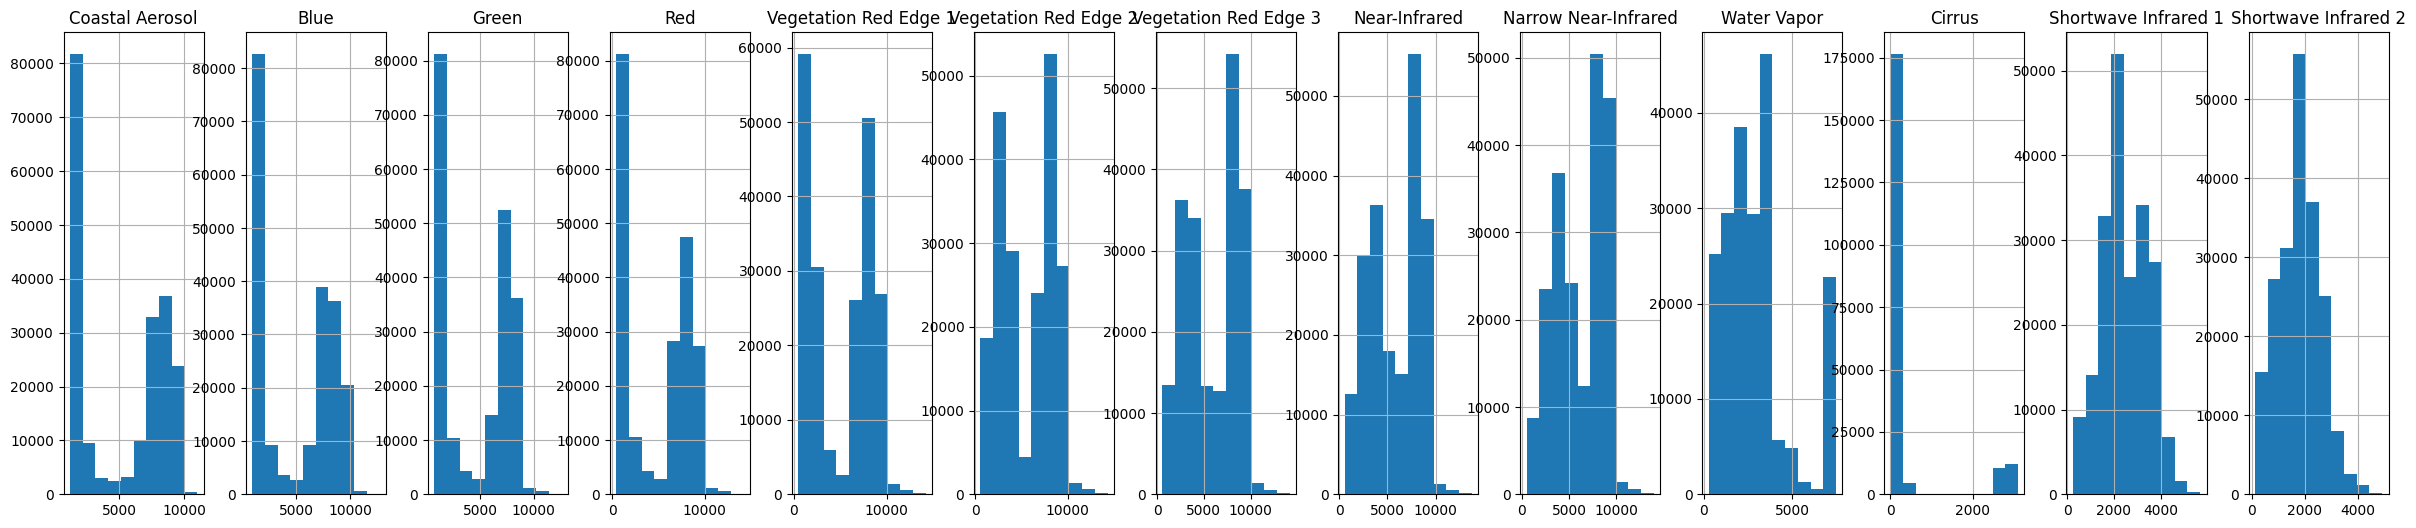

In [6]:
def build_total_df_and_gt(df_list):
    # Return a tuple:
    # X_df: a concatonated dataframe containing band information only, and 
    # y: a concatenated GT array
    # Thus X_df, y are ready to be fed to sklearn
    
    df_list_feats_only = [df.iloc[:, :13] for df in df_list]
    gt_list = [np.array(df['SCL']) for df in df_list]
    
    X_df = pd.concat(df_list_feats_only)
    y = np.hstack(gt_list)
    y = (y==11)   # 11 is "Snow"
    return X_df, y
    
def test_build_total_df_and_gt():
    path_list, df_list = build_feats_and_gt_lists(max_cloud_cover_pc=50, only_every=100)
    X_df, y = build_total_df_and_gt(df_list)
    print(f"Total #pixels: {len(X_df)}, class counts: {Counter(y)}")
    fig, axis = plt.subplots(1, 13, figsize=(30,6))
    X_df.hist(ax=axis)
    plt.show()
    assert len(X_df) == len(y)
    
test_build_total_df_and_gt()
    


## Split robustly on a patch basis

In [7]:
# Get a list of all the available top-level patch names
patch_names = [p.split(base_path)[1] for p in glob.glob(base_path + '/*')]
patch_names

['Beinn_a_Bhuird',
 'Ciste_Mhearad',
 'An_Riabhachan',
 'Coire_Cruach_Sneachda',
 'Beinn_Mhanach',
 'Carn_na_Caim',
 'An_Stuc',
 'Aonach_Beag']

In [8]:
# Assign patches roughly 2/3 : 1/3  train:test
cut_i = int(len(patch_names) * (2/3))
train_patches = patch_names[:cut_i]
test_patches = patch_names[cut_i:]
assert len(train_patches + test_patches) == len(patch_names)
train_patches, test_patches

(['Beinn_a_Bhuird',
  'Ciste_Mhearad',
  'An_Riabhachan',
  'Coire_Cruach_Sneachda',
  'Beinn_Mhanach'],
 ['Carn_na_Caim', 'An_Stuc', 'Aonach_Beag'])

In [9]:
def matches_list(p, patch_list):
    return any([pl in p for pl in patch_list])
    
def test_matches_list():
    patch_list = ['An_Stuc', 'Beinn_a_Bhuird']
    assert matches_list ('blah/An_Stuc/blah2234', patch_list)
    assert not matches_list('blah/Alps/blah564', patch_list)
test_matches_list()

In [10]:
path_list, df_list = build_feats_and_gt_lists(max_cloud_cover_pc=20, only_every=1)

train_path_list, train_df_list = list(zip(*[(path, df) for path, df in zip(path_list, df_list) if matches_list(path, train_patches)]))
test_path_list, test_df_list = list(zip(*[(path, df) for path, df in zip(path_list, df_list) if matches_list(path, test_patches)]))
assert len(train_df_list) + len(test_df_list) == len(df_list)
print(len(train_df_list), len(test_df_list), len(df_list))


Rejecting, ../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_2018...
Rejecting, ../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_2018...
Rejecting, ../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_2018...
Rejecting, ../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_2018...
Rejecting, ../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_2018...
Rejecting, ../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_2018...
Rejecting, ../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_2018...
Rejecting, ../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_2018...
No GT for ../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_2018, skipping
Rejecting, ../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_2018...
Rejecting, ../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_2018...
Rejecting, ../data_murray/An_Riabhachan/l1c/2018-05-01-2018

Rejecting, ../data_murray/An_Riabhachan/l1c/2020-05-01-2020-09-30/S2A_MSIL1C_2020...
Rejecting, ../data_murray/An_Riabhachan/l1c/2020-05-01-2020-09-30/S2A_MSIL1C_2020...
Rejecting, ../data_murray/An_Riabhachan/l1c/2020-05-01-2020-09-30/S2A_MSIL1C_2020...
Rejecting, ../data_murray/An_Riabhachan/l1c/2020-05-01-2020-09-30/S2A_MSIL1C_2020...
Rejecting, ../data_murray/An_Riabhachan/l1c/2020-05-01-2020-09-30/S2A_MSIL1C_2020...
Rejecting, ../data_murray/An_Riabhachan/l1c/2020-05-01-2020-09-30/S2B_MSIL1C_2020...
Rejecting, ../data_murray/An_Riabhachan/l1c/2020-05-01-2020-09-30/S2B_MSIL1C_2020...
Rejecting, ../data_murray/An_Riabhachan/l1c/2020-05-01-2020-09-30/S2B_MSIL1C_2020...
Rejecting, ../data_murray/An_Riabhachan/l1c/2020-05-01-2020-09-30/S2B_MSIL1C_2020...
Rejecting, ../data_murray/An_Riabhachan/l1c/2020-05-01-2020-09-30/S2B_MSIL1C_2020...
Rejecting, ../data_murray/An_Riabhachan/l1c/2020-05-01-2020-09-30/S2B_MSIL1C_2020...
Rejecting, ../data_murray/An_Riabhachan/l1c/2020-05-01-2020-09-30

Rejecting, ../data_murray/An_Riabhachan/l1c/2022-05-01-2022-09-30/S2A_MSIL1C_2022...
Rejecting, ../data_murray/An_Riabhachan/l1c/2022-05-01-2022-09-30/S2A_MSIL1C_2022...
Rejecting, ../data_murray/An_Riabhachan/l1c/2022-05-01-2022-09-30/S2B_MSIL1C_2022...
Rejecting, ../data_murray/An_Riabhachan/l1c/2022-05-01-2022-09-30/S2B_MSIL1C_2022...
Rejecting, ../data_murray/An_Riabhachan/l1c/2022-05-01-2022-09-30/S2B_MSIL1C_2022...
Rejecting, ../data_murray/An_Riabhachan/l1c/2022-05-01-2022-09-30/S2B_MSIL1C_2022...
Rejecting, ../data_murray/An_Riabhachan/l1c/2022-05-01-2022-09-30/S2B_MSIL1C_2022...
Rejecting, ../data_murray/An_Riabhachan/l1c/2022-05-01-2022-09-30/S2B_MSIL1C_2022...
Rejecting, ../data_murray/An_Riabhachan/l1c/2022-05-01-2022-09-30/S2B_MSIL1C_2022...
Rejecting, ../data_murray/An_Riabhachan/l1c/2022-05-01-2022-09-30/S2B_MSIL1C_2022...
Rejecting, ../data_murray/An_Riabhachan/l1c/2022-05-01-2022-09-30/S2B_MSIL1C_2022...
Rejecting, ../data_murray/An_Riabhachan/l1c/2022-05-01-2022-09-30

Rejecting, ../data_murray/An_Stuc/l1c/2020-05-01-2020-09-30/S2A_MSIL1C_20200711T1...
Rejecting, ../data_murray/An_Stuc/l1c/2020-05-01-2020-09-30/S2A_MSIL1C_20200714T1...
Rejecting, ../data_murray/An_Stuc/l1c/2020-05-01-2020-09-30/S2A_MSIL1C_20200724T1...
Rejecting, ../data_murray/An_Stuc/l1c/2020-05-01-2020-09-30/S2A_MSIL1C_20200731T1...
Rejecting, ../data_murray/An_Stuc/l1c/2020-05-01-2020-09-30/S2A_MSIL1C_20200803T1...
Rejecting, ../data_murray/An_Stuc/l1c/2020-05-01-2020-09-30/S2A_MSIL1C_20200810T1...
Rejecting, ../data_murray/An_Stuc/l1c/2020-05-01-2020-09-30/S2A_MSIL1C_20200813T1...
Rejecting, ../data_murray/An_Stuc/l1c/2020-05-01-2020-09-30/S2A_MSIL1C_20200820T1...
Rejecting, ../data_murray/An_Stuc/l1c/2020-05-01-2020-09-30/S2A_MSIL1C_20200823T1...
Rejecting, ../data_murray/An_Stuc/l1c/2020-05-01-2020-09-30/S2A_MSIL1C_20200830T1...
Rejecting, ../data_murray/An_Stuc/l1c/2020-05-01-2020-09-30/S2A_MSIL1C_20200902T1...
Rejecting, ../data_murray/An_Stuc/l1c/2020-05-01-2020-09-30/S2A_M

Rejecting, ../data_murray/An_Stuc/l1c/2022-05-01-2022-09-30/S2A_MSIL1C_20220909T1...
Rejecting, ../data_murray/An_Stuc/l1c/2022-05-01-2022-09-30/S2A_MSIL1C_20220912T1...
Rejecting, ../data_murray/An_Stuc/l1c/2022-05-01-2022-09-30/S2A_MSIL1C_20220919T1...
Rejecting, ../data_murray/An_Stuc/l1c/2022-05-01-2022-09-30/S2A_MSIL1C_20220922T1...
Rejecting, ../data_murray/An_Stuc/l1c/2022-05-01-2022-09-30/S2A_MSIL1C_20220929T1...
Rejecting, ../data_murray/An_Stuc/l1c/2022-05-01-2022-09-30/S2B_MSIL1C_20220507T1...
Rejecting, ../data_murray/An_Stuc/l1c/2022-05-01-2022-09-30/S2B_MSIL1C_20220510T1...
Rejecting, ../data_murray/An_Stuc/l1c/2022-05-01-2022-09-30/S2B_MSIL1C_20220517T1...
Rejecting, ../data_murray/An_Stuc/l1c/2022-05-01-2022-09-30/S2B_MSIL1C_20220520T1...
Rejecting, ../data_murray/An_Stuc/l1c/2022-05-01-2022-09-30/S2B_MSIL1C_20220527T1...
Rejecting, ../data_murray/An_Stuc/l1c/2022-05-01-2022-09-30/S2B_MSIL1C_20220530T1...
Rejecting, ../data_murray/An_Stuc/l1c/2022-05-01-2022-09-30/S2B_M

Rejecting, ../data_murray/Aonach_Beag/l1c/2019-05-01-2019-09-30/S2B_MSIL1C_201906...
Rejecting, ../data_murray/Aonach_Beag/l1c/2019-05-01-2019-09-30/S2B_MSIL1C_201906...
Rejecting, ../data_murray/Aonach_Beag/l1c/2019-05-01-2019-09-30/S2B_MSIL1C_201906...
Rejecting, ../data_murray/Aonach_Beag/l1c/2019-05-01-2019-09-30/S2B_MSIL1C_201906...
Rejecting, ../data_murray/Aonach_Beag/l1c/2019-05-01-2019-09-30/S2B_MSIL1C_201906...
Rejecting, ../data_murray/Aonach_Beag/l1c/2019-05-01-2019-09-30/S2B_MSIL1C_201906...
Rejecting, ../data_murray/Aonach_Beag/l1c/2019-05-01-2019-09-30/S2B_MSIL1C_201907...
Rejecting, ../data_murray/Aonach_Beag/l1c/2019-05-01-2019-09-30/S2B_MSIL1C_201907...
Rejecting, ../data_murray/Aonach_Beag/l1c/2019-05-01-2019-09-30/S2B_MSIL1C_201907...
Rejecting, ../data_murray/Aonach_Beag/l1c/2019-05-01-2019-09-30/S2B_MSIL1C_201907...
Rejecting, ../data_murray/Aonach_Beag/l1c/2019-05-01-2019-09-30/S2B_MSIL1C_201907...
Rejecting, ../data_murray/Aonach_Beag/l1c/2019-05-01-2019-09-30/S

Rejecting, ../data_murray/Aonach_Beag/l1c/2021-05-01-2021-09-30/S2B_MSIL1C_202106...
Rejecting, ../data_murray/Aonach_Beag/l1c/2021-05-01-2021-09-30/S2B_MSIL1C_202106...
Rejecting, ../data_murray/Aonach_Beag/l1c/2021-05-01-2021-09-30/S2B_MSIL1C_202107...
Rejecting, ../data_murray/Aonach_Beag/l1c/2021-05-01-2021-09-30/S2B_MSIL1C_202107...
Rejecting, ../data_murray/Aonach_Beag/l1c/2021-05-01-2021-09-30/S2B_MSIL1C_202107...
Rejecting, ../data_murray/Aonach_Beag/l1c/2021-05-01-2021-09-30/S2B_MSIL1C_202107...
Rejecting, ../data_murray/Aonach_Beag/l1c/2021-05-01-2021-09-30/S2B_MSIL1C_202107...
Rejecting, ../data_murray/Aonach_Beag/l1c/2021-05-01-2021-09-30/S2B_MSIL1C_202108...
Rejecting, ../data_murray/Aonach_Beag/l1c/2021-05-01-2021-09-30/S2B_MSIL1C_202108...
Rejecting, ../data_murray/Aonach_Beag/l1c/2021-05-01-2021-09-30/S2B_MSIL1C_202108...
Rejecting, ../data_murray/Aonach_Beag/l1c/2021-05-01-2021-09-30/S2B_MSIL1C_202108...
Rejecting, ../data_murray/Aonach_Beag/l1c/2021-05-01-2021-09-30/S

Rejecting, ../data_murray/Beinn_Mhanach/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_2018...
Rejecting, ../data_murray/Beinn_Mhanach/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_2018...
Rejecting, ../data_murray/Beinn_Mhanach/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_2018...
Rejecting, ../data_murray/Beinn_Mhanach/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_2018...
Rejecting, ../data_murray/Beinn_Mhanach/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_2018...
Rejecting, ../data_murray/Beinn_Mhanach/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_2018...
No GT for ../data_murray/Beinn_Mhanach/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_2018, skipping
Rejecting, ../data_murray/Beinn_Mhanach/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_2018...
Rejecting, ../data_murray/Beinn_Mhanach/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_2018...
Rejecting, ../data_murray/Beinn_Mhanach/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_2018...
Rejecting, ../data_murray/Beinn_Mhanach/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_2018...
Rejecting, ../data_murray/Beinn_Mhanach/l1c/2018-05-01-2018

Rejecting, ../data_murray/Beinn_Mhanach/l1c/2021-05-01-2021-09-30/S2A_MSIL1C_2021...
Rejecting, ../data_murray/Beinn_Mhanach/l1c/2021-05-01-2021-09-30/S2A_MSIL1C_2021...
Rejecting, ../data_murray/Beinn_Mhanach/l1c/2021-05-01-2021-09-30/S2A_MSIL1C_2021...
Rejecting, ../data_murray/Beinn_Mhanach/l1c/2021-05-01-2021-09-30/S2A_MSIL1C_2021...
Rejecting, ../data_murray/Beinn_Mhanach/l1c/2021-05-01-2021-09-30/S2A_MSIL1C_2021...
Rejecting, ../data_murray/Beinn_Mhanach/l1c/2021-05-01-2021-09-30/S2A_MSIL1C_2021...
Rejecting, ../data_murray/Beinn_Mhanach/l1c/2021-05-01-2021-09-30/S2A_MSIL1C_2021...
Rejecting, ../data_murray/Beinn_Mhanach/l1c/2021-05-01-2021-09-30/S2A_MSIL1C_2021...
Rejecting, ../data_murray/Beinn_Mhanach/l1c/2021-05-01-2021-09-30/S2A_MSIL1C_2021...
Rejecting, ../data_murray/Beinn_Mhanach/l1c/2021-05-01-2021-09-30/S2B_MSIL1C_2021...
Rejecting, ../data_murray/Beinn_Mhanach/l1c/2021-05-01-2021-09-30/S2B_MSIL1C_2021...
Rejecting, ../data_murray/Beinn_Mhanach/l1c/2021-05-01-2021-09-30

Rejecting, ../data_murray/Beinn_a_Bhuird/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_201...
Rejecting, ../data_murray/Beinn_a_Bhuird/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_201...
Rejecting, ../data_murray/Beinn_a_Bhuird/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_201...
Rejecting, ../data_murray/Beinn_a_Bhuird/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_201...
Rejecting, ../data_murray/Beinn_a_Bhuird/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_201...
Rejecting, ../data_murray/Beinn_a_Bhuird/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_201...
Rejecting, ../data_murray/Beinn_a_Bhuird/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_201...
Rejecting, ../data_murray/Beinn_a_Bhuird/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_201...
Rejecting, ../data_murray/Beinn_a_Bhuird/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_201...
Rejecting, ../data_murray/Beinn_a_Bhuird/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_201...
Rejecting, ../data_murray/Beinn_a_Bhuird/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_201...
Rejecting, ../data_murray/Beinn_a_Bhuird/l1c/2018-05-01-2018-09-3

Rejecting, ../data_murray/Beinn_a_Bhuird/l1c/2021-05-01-2021-09-30/S2A_MSIL1C_202...
Rejecting, ../data_murray/Beinn_a_Bhuird/l1c/2021-05-01-2021-09-30/S2A_MSIL1C_202...
Rejecting, ../data_murray/Beinn_a_Bhuird/l1c/2021-05-01-2021-09-30/S2A_MSIL1C_202...
Rejecting, ../data_murray/Beinn_a_Bhuird/l1c/2021-05-01-2021-09-30/S2A_MSIL1C_202...
Rejecting, ../data_murray/Beinn_a_Bhuird/l1c/2021-05-01-2021-09-30/S2A_MSIL1C_202...
Rejecting, ../data_murray/Beinn_a_Bhuird/l1c/2021-05-01-2021-09-30/S2A_MSIL1C_202...
Rejecting, ../data_murray/Beinn_a_Bhuird/l1c/2021-05-01-2021-09-30/S2A_MSIL1C_202...
Rejecting, ../data_murray/Beinn_a_Bhuird/l1c/2021-05-01-2021-09-30/S2A_MSIL1C_202...
Rejecting, ../data_murray/Beinn_a_Bhuird/l1c/2021-05-01-2021-09-30/S2A_MSIL1C_202...
Rejecting, ../data_murray/Beinn_a_Bhuird/l1c/2021-05-01-2021-09-30/S2A_MSIL1C_202...
Rejecting, ../data_murray/Beinn_a_Bhuird/l1c/2021-05-01-2021-09-30/S2A_MSIL1C_202...
Rejecting, ../data_murray/Beinn_a_Bhuird/l1c/2021-05-01-2021-09-3

Rejecting, ../data_murray/Carn_na_Caim/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_20180...
Rejecting, ../data_murray/Carn_na_Caim/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_20180...
Rejecting, ../data_murray/Carn_na_Caim/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_20180...
Rejecting, ../data_murray/Carn_na_Caim/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_20180...
Rejecting, ../data_murray/Carn_na_Caim/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_20180...
Rejecting, ../data_murray/Carn_na_Caim/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_20180...
Rejecting, ../data_murray/Carn_na_Caim/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_20180...
Rejecting, ../data_murray/Carn_na_Caim/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_20180...
Rejecting, ../data_murray/Carn_na_Caim/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_20180...
Rejecting, ../data_murray/Carn_na_Caim/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_20180...
Rejecting, ../data_murray/Carn_na_Caim/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_20180...
Rejecting, ../data_murray/Carn_na_Caim/l1c/2018-05-01-2018-09-30/

Rejecting, ../data_murray/Carn_na_Caim/l1c/2020-05-01-2020-09-30/S2B_MSIL1C_20200...
Rejecting, ../data_murray/Carn_na_Caim/l1c/2020-05-01-2020-09-30/S2B_MSIL1C_20200...
Rejecting, ../data_murray/Carn_na_Caim/l1c/2020-05-01-2020-09-30/S2B_MSIL1C_20200...
Rejecting, ../data_murray/Carn_na_Caim/l1c/2020-05-01-2020-09-30/S2B_MSIL1C_20200...
Rejecting, ../data_murray/Carn_na_Caim/l1c/2020-05-01-2020-09-30/S2B_MSIL1C_20200...
Rejecting, ../data_murray/Carn_na_Caim/l1c/2020-05-01-2020-09-30/S2B_MSIL1C_20200...
Rejecting, ../data_murray/Carn_na_Caim/l1c/2020-05-01-2020-09-30/S2B_MSIL1C_20200...
Rejecting, ../data_murray/Carn_na_Caim/l1c/2020-05-01-2020-09-30/S2B_MSIL1C_20200...
Rejecting, ../data_murray/Carn_na_Caim/l1c/2020-05-01-2020-09-30/S2B_MSIL1C_20200...
Rejecting, ../data_murray/Carn_na_Caim/l1c/2020-05-01-2020-09-30/S2B_MSIL1C_20200...
Rejecting, ../data_murray/Carn_na_Caim/l1c/2020-05-01-2020-09-30/S2B_MSIL1C_20200...
Rejecting, ../data_murray/Carn_na_Caim/l1c/2020-05-01-2020-09-30/

Rejecting, ../data_murray/Ciste_Mhearad/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_2018...
Rejecting, ../data_murray/Ciste_Mhearad/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_2018...
Rejecting, ../data_murray/Ciste_Mhearad/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_2018...
Rejecting, ../data_murray/Ciste_Mhearad/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_2018...
Rejecting, ../data_murray/Ciste_Mhearad/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_2018...
No GT for ../data_murray/Ciste_Mhearad/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_2018, skipping
Rejecting, ../data_murray/Ciste_Mhearad/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_2018...
Rejecting, ../data_murray/Ciste_Mhearad/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_2018...
Rejecting, ../data_murray/Ciste_Mhearad/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_2018...
Rejecting, ../data_murray/Ciste_Mhearad/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_2018...
Rejecting, ../data_murray/Ciste_Mhearad/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_2018...
Rejecting, ../data_murray/Ciste_Mhearad/l1c/2018-05-01-2018

Rejecting, ../data_murray/Ciste_Mhearad/l1c/2021-05-01-2021-09-30/S2A_MSIL1C_2021...
Rejecting, ../data_murray/Ciste_Mhearad/l1c/2021-05-01-2021-09-30/S2A_MSIL1C_2021...
Rejecting, ../data_murray/Ciste_Mhearad/l1c/2021-05-01-2021-09-30/S2A_MSIL1C_2021...
Rejecting, ../data_murray/Ciste_Mhearad/l1c/2021-05-01-2021-09-30/S2A_MSIL1C_2021...
Rejecting, ../data_murray/Ciste_Mhearad/l1c/2021-05-01-2021-09-30/S2A_MSIL1C_2021...
Rejecting, ../data_murray/Ciste_Mhearad/l1c/2021-05-01-2021-09-30/S2A_MSIL1C_2021...
Rejecting, ../data_murray/Ciste_Mhearad/l1c/2021-05-01-2021-09-30/S2B_MSIL1C_2021...
Rejecting, ../data_murray/Ciste_Mhearad/l1c/2021-05-01-2021-09-30/S2B_MSIL1C_2021...
Rejecting, ../data_murray/Ciste_Mhearad/l1c/2021-05-01-2021-09-30/S2B_MSIL1C_2021...
Rejecting, ../data_murray/Ciste_Mhearad/l1c/2021-05-01-2021-09-30/S2B_MSIL1C_2021...
Rejecting, ../data_murray/Ciste_Mhearad/l1c/2021-05-01-2021-09-30/S2B_MSIL1C_2021...
Rejecting, ../data_murray/Ciste_Mhearad/l1c/2021-05-01-2021-09-30

In [11]:
X_train, y_train = build_total_df_and_gt(train_df_list)
X_test, y_test = build_total_df_and_gt(test_df_list)

In [12]:
# Setup a sklearn Pipeline
pipe = Pipeline([
    ("Scaling", StandardScaler()),
    ("Classifier", QuadraticDiscriminantAnalysis())
])

cls = pipe.fit(np.array(X_train), y_train)

In [13]:
roc_auc_score(y_test, cls.predict_proba(np.array(X_test))[:,1])

0.9470665411647892

In [14]:
confusion_matrix(y_test, cls.predict(np.array(X_test)))

array([[2934925,  184132],
       [  90526,   95755]])

In [15]:
def RGBfromStack13(imStack):
    rgbIm = np.dstack((imStack[:,:,3], imStack[:,:,2], imStack[:,:,1]))
    rgbIm = rgbIm / 2000
    rgbIm = rgbIm.clip(0, 1)
    return rgbIm

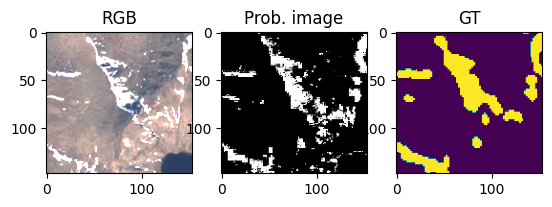

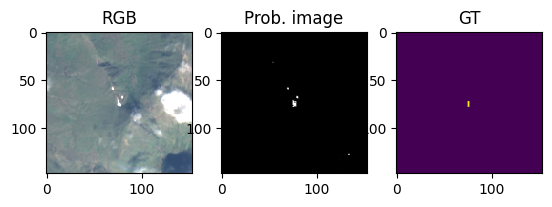

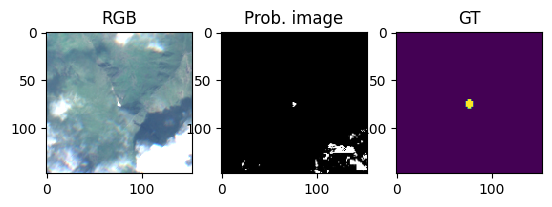

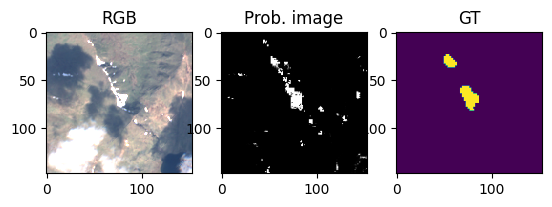

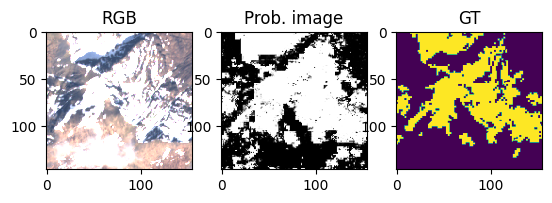

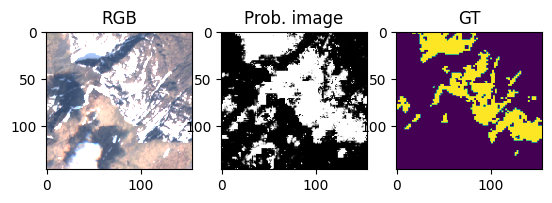

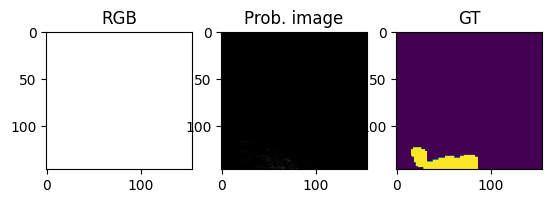

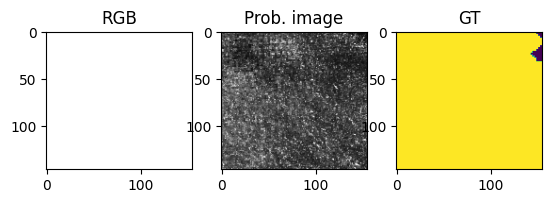

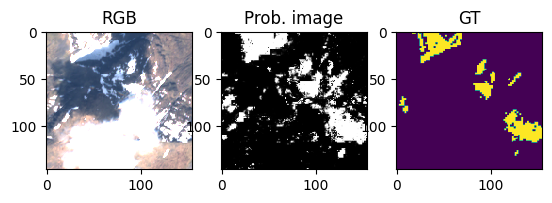

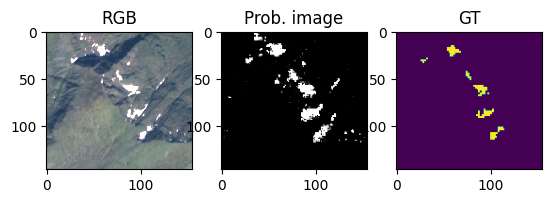

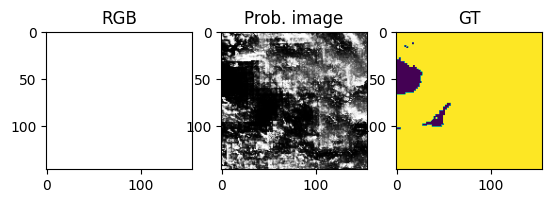

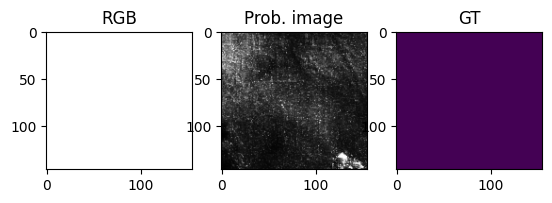

In [16]:
for p1 in test_path_list[:40]:
    # Get the 13 band image
    imStack = np.load(p1)
    nx, ny, nb = imStack.shape
    assert nb == 13
    
    # Get the corresponding GT image.  This has 3 channels, we need the 1st, value 11 means snow.
    p2 = find_corresponding_gt(p1, l2a_list)
    imGT = np.load(p2)[:,:,0] == 11
    if np.sum(imGT) == 0:  # no show!
        continue
     
    # Reshape the 13 band image ready for classification, then reshape back to an image
    
    featsOneIm = imStack.reshape(nx * ny, nb)
    classified_image = cls.predict_proba(featsOneIm)[:,1]
    classified_image = classified_image.reshape(nx, ny)
    
    # Now display three images:  RGB image, probability image, GT image

    plt.subplot(1,3,1)
    plt.imshow(RGBfromStack13(imStack), interpolation='nearest')
    plt.title("RGB")
    plt.subplot(1,3,2)
    plt.imshow(classified_image, cmap='gray', vmin=0, vmax=1)
    plt.title("Prob. image")
    plt.subplot(1,3,3)
    plt.imshow(imGT)
    plt.title("GT")
    plt.show()